In [5]:
# imports and settings
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sns
import nglview as nv                            # for visualisation
from MDAnalysis.analysis.align import alignto   # for aligning structures
from MDAnalysis.analysis.pca import PCA         # for PCA
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP                   # for secondary structure selection
from Bio.PDB.SASA import ShrakeRupley           # for SASA calculation
from IPython.display import display             # for data frame display
from multiprocessing import Pool                # for multiprocessing
from tqdm import tqdm                           # for progress bars

# surpress warnings
warnings.filterwarnings(action='ignore', module='matplotlib')
warnings.filterwarnings(action='ignore', module='mdanalysis')
warnings.filterwarnings('ignore')

# pandas settings
pd.set_option('display.max_colwidth', None)

############################################################################################################

# base directories
base_directory = "/biggin/b212/bioc1781/Projects/CTNS/human/monomer/red-msa/with-dropout/" #"/biggin/b212/bioc1781/Projects/KDELR/red-msa/"  #"/biggin/b212/bioc1781/Projects/CTNS/human/monomer/red-msa/with-dropout/"
structure_directory = base_directory + "ensemble/" # directory with the AF2 ensemble, cannot be the same as base directory

# settings
selection_for_writeout  = "protein and name CA"  # useful if you want all the outputs to have a specific selection
conserved_residues      = "resid 162 or resid 281 or resid 142 or resid 143 or resid 346 or resid 345 or resid 305 or resid 280 or resid 138 or resid 211 or resid 208 or resid 273 or resid 173 or resid 335 or resid 205 or resid 332 or resid 176 " #"resid 205 or resid 305 or resid 346 or resid 169 or resid 308 or resid 339 or resid 260 or resid 158 or resid 338 or resid 177 or resid 288 or resid 222 or resid 139 or resid 141 or resid 298 or resid 182 or resid 280 or resid 335 or resid 142 or resid 138 or resid 170 or resid 208 or resid 173 or resid 134"        #'resid 205 or resid 305 or resid 346 or resid 169 or resid 308 or resid 339 or resid 260 or resid 158 or resid 338 or resid 177 or resid 288 or resid 222 or resid 139 or resid 141 or resid 298 or resid 182 or resid 280 or resid 335 or resid 142 or resid 138 or resid 170 or resid 208 or resid 173 or resid 134'
excluded_residues       = ""        # resid 134-149
resid_offset    = 115 #0 #115            # first resID in the reference structures if the chain does not start from 1
# structure filtering   
thresh_rmsd     = 10 #6             # threshold for discarding structures based on RMSD
thresh_pLDDT    = 90                # threshold for discarding structures based on pLDDT
thresh_sasa_coeff = 100             # multiple of highest sasa of the reference structure above which structures are discarded
#diffmat_thresh  = 0                # threshold for ignoring atoms in RMSD calculations based on how much they differ between the reference structures
# analysis  
num_processes   = 12                # CPU cores to use for multiprocessing
n_pcs           = 3                 # number of principal components to keep in PCA
# monte carlo   
mc_temp         = 500               # monte carlo temperature
mc_wf_sasa      = 0                 # monte carlo energy function weight factor for SASA (check if this should be -ve, depends on order of subtraction and matrix indexing)
mc_n_runs       = 1                 # number of monte carlo runs
mc_n_bins       = 24                # so mc_n_bins is the total number of bins (because of reference structures and zero indexing)
collective_variable = 'cyto_helix_bundle_separation'         # collective_variable to bin for path finding
start_from_endstates = False
# for plotting
plot_variable_1     = 'lumen_helix_bundle_separation'   
plot_variable_2     = 'cyto_helix_bundle_separation'
plot_variable_3     = 'sasa'

os.environ["OMP_NUM_THREADS"] = str(num_processes)

############################################################################################################

# reference structures
use_reference_structures = True

if use_reference_structures:

    outward_open_pdb = base_directory + "8DKE_cytosol_noNTD_hydrogens.pdb"
    inward_open_pdb  = base_directory + "8DKI_lumen_noNTD_hydrogens.pdb"

    # universes for reference structures
    u_outward_open = mda.Universe(outward_open_pdb, outward_open_pdb)
    u_inward_open  = mda.Universe(inward_open_pdb, inward_open_pdb)

    # align reference structures to eachother
    
    alignto(u_inward_open, u_outward_open, select='all', weights="mass")

    # write reindexed pdbs of reference structures for inclusion in the ensemble
    u_outward_open.atoms.residues.resids -= resid_offset
    u_outward_open.atoms.write(structure_directory + "ref_outward.pdb")
    u_outward_open.atoms.residues.resids += resid_offset
    #
    u_inward_open.atoms.residues.resids -= resid_offset
    u_inward_open.atoms.write(structure_directory + "ref_inward.pdb")
    u_inward_open.atoms.residues.resids += resid_offset

else:
    outward_open_pdb = None
    inward_open_pdb  = None



In [6]:
# retrieve structures

# user specific - do whatever you need here to get a dictionary of structures and their associated pLDDT values

# # ONLY NEED TO RUN ONCE 
# # copy structures from outputs to ensemble
# msa_depths = ['32-64', '64-128', '128-256', '256-512', '512-1024']
# 
# for msa in msa_depths:
#     structures_msa = [f for f in os.listdir(base_directory + 'output_' + msa) if f.endswith('.pdb')]
#     for structure in structures_msa:
#         # copy all the pdb files with "_relaxed_" in the name to the structure directory
#         if "_relaxed_" in structure:
#             # get the rank of the strcuture (last thing before the file extension)
#             rank = 'rank_' + structure.split('_')[structure.split('_').index('rank')+1]
#             os.system('cp ' + base_directory + 'output_' + msa + '/' + structure + ' ' + structure_directory + '/msa-' + msa + '_' + rank + '.pdb')
# 
# # get list of all files in structure directory directory with the pdb extension
# structures = [f for f in os.listdir(structure_directory) if f.endswith('.pdb')]
# structures.sort()

# associate structures with pLDDT values
structure_and_pLDDT = {}

msa_depths = ['8-16', '16-32', '32-64', '64-128', '128-256', '256-512', '512-1024']
for msa in msa_depths:
    structures_msa = [f for f in os.listdir(structure_directory) if f.endswith('.pdb') and msa in f and str(msa) in f]
    log_file = structure_directory + msa + "_log.txt"   # look up the corresponding log file
    for structure in structures_msa:
        rank = 'rank_' + structure.split('_')[structure.split('_').index('rank')+1] # get the rank of the structure
        rank = rank.split('.')[0]           # remove the file extension
        with open(log_file, "r") as file:
            for line in file:               # match the rank with the pLDDT value
                if rank in line:
                    pLDDT = line.split()[3].replace('pLDDT=','')
                    structure_and_pLDDT[structure] = float(pLDDT)
                    break

print('Structures:', len(structure_and_pLDDT))

# if no reference structures, chose 2 hightest pLDDT structures as references
if not use_reference_structures:
    # get the 2 structures with the highest pLDDT values
    ref_structures = sorted(structure_and_pLDDT, key=structure_and_pLDDT.get, reverse=True)[:2]
    print('Reference structures:', ref_structures)
    # declare the appropriate variable (the name of the structure file)
    outward_open_pdb = structure_directory + ref_structures[0]
    inward_open_pdb  = structure_directory + ref_structures[1]
    # universes for reference structures
    u_outward_open = mda.Universe(outward_open_pdb, outward_open_pdb)
    u_inward_open  = mda.Universe(inward_open_pdb, inward_open_pdb)

    # align reference structures to eachother
    alignto(u_inward_open, u_outward_open, select='protein', weights="mass")

    # write reindexed pdbs of reference structures for inclusion in the ensemble
    #u_outward_open.atoms.residues.resids -= resid_offset
    #u_outward_open.atoms.write(structure_directory + "ref_outward.pdb")
    #u_outward_open.atoms.residues.resids += resid_offset
    #
    #u_inward_open.atoms.residues.resids -= resid_offset
    #u_inward_open.atoms.write(structure_directory + "ref_inward.pdb")
    #u_inward_open.atoms.residues.resids += resid_offset


Structures: 14000


In [7]:
# automatic "clever" selection definer

# temporary universe
u = u_outward_open

# identify regions of secondary structure
p = PDBParser()
structure = p.get_structure('reference', outward_open_pdb)
model = structure[0]
dssp = DSSP(model, outward_open_pdb, dssp='mkdssp')

helices = []
sheets  = []
loops   = []

# get secondary structure labels for resIDs
for key in dssp.keys():
    if dssp[key][2] == 'H' or dssp[key][2] == 'G' or dssp[key][2] == 'I':
        helices.append(key[1][1])
    elif dssp[key][2] == 'E':
        sheets.append(key[1][1])
    elif dssp[key][2] == 'T' or dssp[key][2] == 'S':
        loops.append(key[1][1])
    
helices = sorted(list(set(helices)))
sheets = sorted(list(set(sheets)))
loops = sorted(list(set(loops)))

helices_contiguous = []
sheets_contiguous  = []
loops_contiguous   = []

# get contiguous regions of secondary structure
for i in range(len(helices)):
    if i == 0:
        helices_contiguous.append([helices[i]])
    elif helices[i] == helices[i-1] + 1:
        helices_contiguous[-1].append(helices[i])
    else:
        helices_contiguous.append([helices[i]])

for i in range(len(sheets)):
    if i == 0:
        sheets_contiguous.append([sheets[i]])
    elif sheets[i] == sheets[i-1] + 1:
        sheets_contiguous[-1].append(sheets[i])
    else:
        sheets_contiguous.append([sheets[i]])

for i in range(len(loops)):
    if i == 0:
        loops_contiguous.append([loops[i]])
    elif loops[i] == loops[i-1] + 1:
        loops_contiguous[-1].append(loops[i])
    else:
        loops_contiguous.append([loops[i]])

selection_helices = []
selection_sheets  = []
selection_loops   = []

# make mdanalysis selections corresponding to these regions
for i in range(len(helices_contiguous)):
    selection_helices.append('(resid %s-%s)' % (helices_contiguous[i][0], helices_contiguous[i][-1]))
for i in range(len(sheets_contiguous)):
    selection_sheets.append('(resid %s-%s)' % (sheets_contiguous[i][0], sheets_contiguous[i][-1]))
for i in range(len(loops_contiguous)):
    selection_loops.append('(resid %s-%s)' % (loops_contiguous[i][0], loops_contiguous[i][-1]))

# conserved residues
selection_conserved_residues = '((' + conserved_residues + ') and (name CA or name CG or name CZ* or name NZ))' 

# format selections
selection_helices = ','.join(selection_helices)
selection_helices = selection_helices.replace(',', ' or ')
selection_sheets = ','.join(selection_sheets)
selection_sheets = selection_sheets.replace(',', ' or ')
selection_loops = ','.join(selection_loops)
selection_loops = selection_loops.replace(',', ' or ')

endstates = {}

resids_from_ca_dist_diffmat = []

## get the resid of the residues that differ by more than the threshold in absolute terms
#above_thresh = np.where(abs(ca_dist_difference_matrix) >= diffmat_thresh)
#for i in range(len(above_thresh[0])):
#    resids_from_ca_dist_diffmat.append(u.atoms[above_thresh[0][i]].resid)
#resids_from_ca_dist_diffmat = list(set(resids_from_ca_dist_diffmat))    # get unique residues

# make a selection token for these residues
selection_from_ca_dist_diffmat = []
for i in range(len(resids_from_ca_dist_diffmat)):
    selection_from_ca_dist_diffmat.append('resid %s' % resids_from_ca_dist_diffmat[i])
selection_from_ca_dist_diffmat = ','.join(selection_from_ca_dist_diffmat)
selection_from_ca_dist_diffmat = selection_from_ca_dist_diffmat.replace(',', ' or ')

# final rmsd_selection for analysis
rmsd_selection = '( ( (' + selection_helices + ') and name CA ) or ( (' + selection_loops + ') and name CA ) )' # or' + selection_conserved_residues #+ ' and not (resid 116-120 or resid 356-367)'
if conserved_residues != "":
    rmsd_selection += ' or ( (' + selection_helices + ') and' + selection_conserved_residues + ')'
if excluded_residues != "":
    rmsd_selection += ' and not (' + excluded_residues + ')'

print(rmsd_selection)

# write a pdb of the selection
# select the rmsd_selection atoms in the outward open structure
check = u.select_atoms(rmsd_selection)
# write out the selection
check.write(base_directory + 'rmsd_selection.pdb')




( ( ((resid 121-139) or (resid 142-152) or (resid 160-181) or (resid 184-193) or (resid 203-225) or (resid 235-257) or (resid 264-290) or (resid 300-322) or (resid 338-356)) and name CA ) or ( ((resid 119-119) or (resid 140-141) or (resid 153-153) or (resid 156-158) or (resid 182-182) or (resid 194-196) or (resid 200-200) or (resid 226-226) or (resid 230-230) or (resid 258-259) or (resid 261-263) or (resid 291-292) or (resid 296-296) or (resid 299-299) or (resid 323-324) or (resid 326-326) or (resid 328-331) or (resid 333-337)) and name CA ) ) or ( ((resid 121-139) or (resid 142-152) or (resid 160-181) or (resid 184-193) or (resid 203-225) or (resid 235-257) or (resid 264-290) or (resid 300-322) or (resid 338-356)) and((resid 162 or resid 281 or resid 142 or resid 143 or resid 346 or resid 345 or resid 305 or resid 280 or resid 138 or resid 211 or resid 208 or resid 273 or resid 173 or resid 335 or resid 205 or resid 332 or resid 176 ) and (name CA or name CG or name CZ* or name NZ)))


In [8]:
# make main pandas dataframe and filter data
ensemble_df = pd.DataFrame(index=structure_and_pLDDT.keys())
# rename the index column to structure
ensemble_df.index.names = ['structure']

pLDDT_scores = {}
plddt_df = pd.DataFrame(list(structure_and_pLDDT.items()), columns=['structure', 'pDDLDT']) # Convert the dictionary to a DataFrame

# add entries to dictionary for the reference structures with pLDDT scores of 100
if use_reference_structures:
    plddt_df = pd.concat([plddt_df, pd.DataFrame({'structure': 'ref_outward.pdb', 'pDDLDT': 100}, index=[0])], ignore_index=True)   # append is deprecated, use concat instead
    plddt_df = pd.concat([plddt_df, pd.DataFrame({'structure': 'ref_inward.pdb', 'pDDLDT': 100}, index=[0])], ignore_index=True)

# Merge the two DataFrames on the structure column
ensemble_df = pd.merge(ensemble_df, plddt_df, on='structure')

# filter by pLDDT
ensemble_df = ensemble_df[ensemble_df['pDDLDT'] > thresh_pLDDT]      # discard < thresh_pLDDT
structures = list(ensemble_df['structure'])                          # apply the filter to the list of structure names

display(ensemble_df)

,structure,pDDLDT
2001,msa-16-32_rank_041.pdb,90.8
2016,msa-16-32_rank_040.pdb,90.8
2024,msa-16-32_rank_042.pdb,90.8
2028,msa-16-32_rank_017.pdb,91.2
2046,msa-16-32_rank_083.pdb,90.3
...,...,...
13987,msa-512-1024_rank_368.pdb,90.6
13989,msa-512-1024_rank_348.pdb,90.8
13990,msa-512-1024_rank_241.pdb,91.2
13991,msa-512-1024_rank_200.pdb,91.4


,PC1,PC2,PC3,structure
0,3.654477,6.548594,-5.352394,2001
1,-1.069209,6.685546,0.272795,2016
2,0.369558,3.753401,-0.308074,2024
3,3.699788,7.435911,-2.735841,2028
4,2.893365,6.969085,-1.609437,2046


,PC cumulated variance
0,68.0
1,85.0
2,89.0
3,91.0
4,92.0


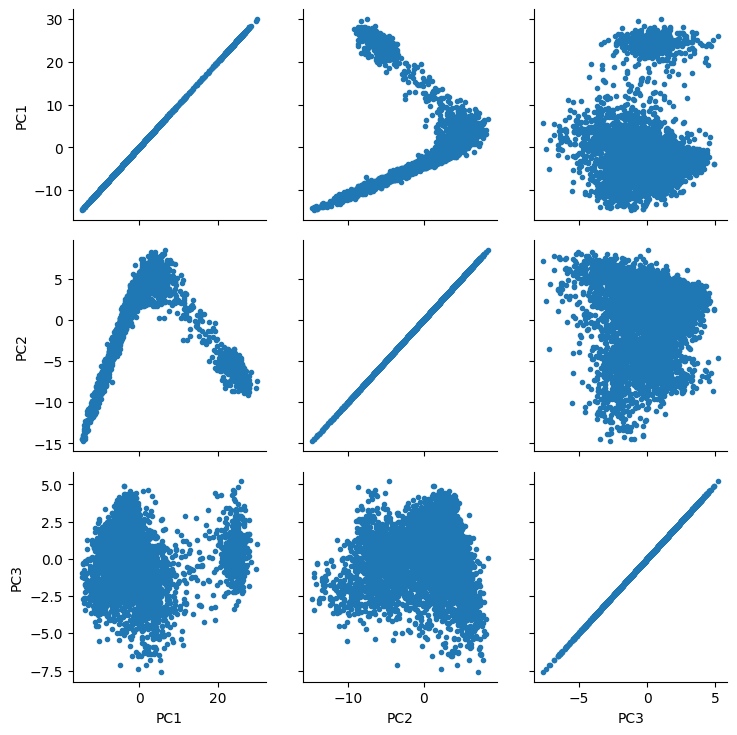

In [9]:
# run PCA on the ensemble

# write a multistate pdb file for the whole ensemble so MDA will interpret it as a trajectory
with mda.Writer(base_directory + 'ensemble.pdb', u.atoms.n_atoms) as W:
    for structure in ensemble_df['structure']:
        u = mda.Universe(structure_directory + structure, 
                         structure_directory + structure)
        # renumber for consistency and to match selection token   s     
        u.atoms.residues.resids += resid_offset
        u.atoms.segments.segids = 'A'
        u.atoms.chainIDs = 'A'
        W.write(u.select_atoms(rmsd_selection))
 
# make a universe containing all the structures
u = mda.Universe(base_directory + "ensemble.pdb")

# align the ensemble to the selection token
aligner = mda.analysis.align.AlignTraj(u, u, select=rmsd_selection, in_memory=True).run()

# perform principal component analysis
pc = PCA(u, select=rmsd_selection, align=True, mean=None, n_components=None).run()

# project coorindates onto the principal components
pc_projection = pc.transform(u.select_atoms(rmsd_selection), n_components=n_pcs)

# make a dataframe to store the principal components
pca_df = pd.DataFrame(pc_projection, columns=['PC{}'.format(i+1) for i in range(n_pcs)])
pca_df['structure'] = ensemble_df.index

# print out the PCs
display(pd.DataFrame(pca_df).head())

# show table of variances explained by each PC
display(pd.DataFrame((pc.cumulated_variance*100).round(), columns=['PC cumulated variance']).head())

#drop the structure column for plotting
pca_df_pairgrid = pca_df.drop('structure', axis=1)
g = sns.PairGrid(pca_df_pairgrid)
g.map(plt.scatter, marker='.')
plt.show()
pca_df_pairgrid = None

# add principal components to the dataframe - making sure the structures are in the same order
pca_df = pca_df.sort_values(by=['structure'])
pca_df = pca_df.reset_index(drop=True)
ensemble_df['PC1'] = pca_df['PC1'].values
ensemble_df['PC2'] = pca_df['PC2'].values
ensemble_df['PC3'] = pca_df['PC3'].values

# visualisation
n_pcs = 3
for i in range(n_pcs):
    pc_n =    pc.p_components[:, i]
    trans_n =   pc_projection[:, i]
    projected = np.outer(trans_n, pc_n) + pc.mean.flatten()
    coordinates = projected.reshape(len(trans_n), -1, 3)
    
    proj_n = mda.Merge(u.select_atoms(rmsd_selection))
    proj_n.load_new(coordinates)
    
    # write this to a multistate pdb file
    with mda.Writer(base_directory + 'pca{}.pdb'.format(i+1), proj_n.atoms.n_atoms) as W:
        for ts in proj_n.trajectory:
            W.write(proj_n.atoms)

Top pLDDT per cluster:


,structure,pDDLDT,PC1,PC2,PC3,cluster
8396,msa-128-256_rank_001.pdb,94.3,-1.440329,4.143236,1.744184,0
5738,msa-32-64_rank_021.pdb,92.9,26.695212,-8.672450,2.552981,1


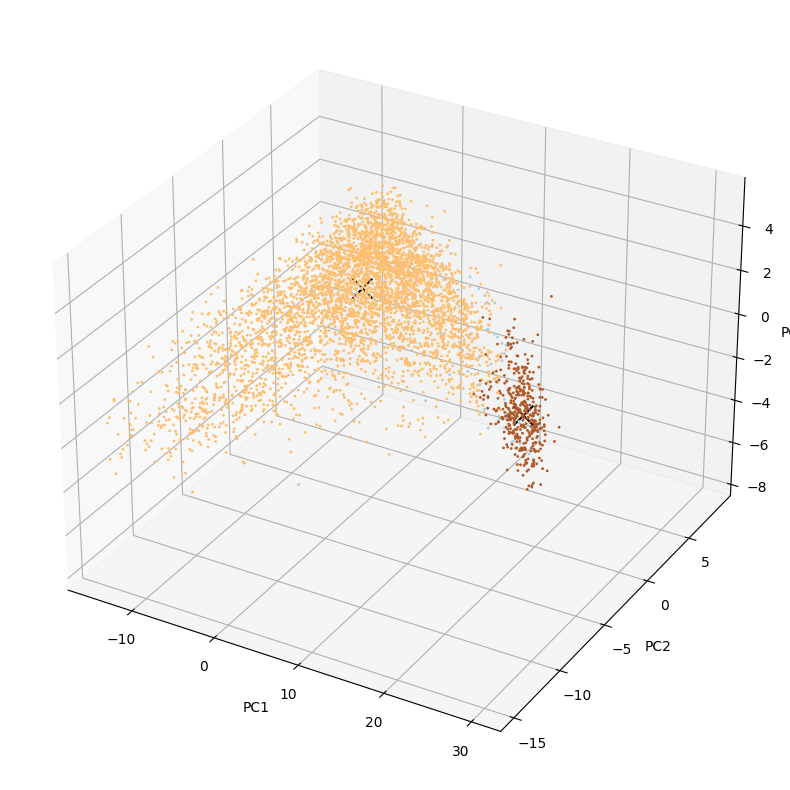

In [10]:
# select references structures for which to perform rmsd calculations below
from sklearn.cluster import HDBSCAN

# min samples is 10 percent of size of ensemble
clustering_min_samples = int(len(ensemble_df) * 0.01)

cluster = HDBSCAN(min_samples=clustering_min_samples, store_centers="medoid").fit(ensemble_df[['PC1', 'PC2', 'PC3']])

# add the cluster labels to the dataframe
ensemble_df['cluster'] = cluster.labels_

# get the number of clusters that are not noise (-1)
num_clusters = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)

# plot the clusters
#plt.scatter(ensemble_df['PC1'], ensemble_df['PC2'], c=ensemble_df['cluster'], cmap='viridis')

cluster_representatives = []
for i in cluster.medoids_:
    # lookup the relevant structures in the dataframe (using medoid guarantees this has been sampled)
    cluster_representatives.append(ensemble_df[(ensemble_df['PC1'] == i[0]) & (ensemble_df['PC2'] == i[1]) & (ensemble_df['PC3'] == i[2])]['structure'].values[0])

cluster_best_pLDDT = []
# for each cluster number, get the structure with the highest pLDDT
for i in range(num_clusters):
    cluster_best_pLDDT.append(ensemble_df[ensemble_df['cluster'] == i].sort_values(by=['pDDLDT'], ascending=False)['structure'].values[0])
    
# plot the cluster representatives
#for i in cluster_representatives:
#    plt.scatter(ensemble_df[(ensemble_df['structure'] == i)]['PC1'], ensemble_df[(ensemble_df['structure'] == i)]['PC2'], c='red', marker='x', s=100)

# display the cluster representatives in the dataframe
#print('Cluster centroids (medoids):')
#display(ensemble_df[ensemble_df['structure'].isin(ref_structures)])

# display the best structures per cluster 
print('Top pLDDT per cluster:')
display(ensemble_df[ensemble_df['structure'].isin(cluster_best_pLDDT)].sort_values(by=['pDDLDT'], ascending=False))

ref_structures = cluster_representatives

# diversity pick of structures from the over

xaxis = 'PC1'
yaxis = 'PC2'
zaxis = 'PC3'

# 3D plot of the ensemble
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ensemble_df[xaxis], ensemble_df[yaxis], ensemble_df[zaxis], c=ensemble_df['cluster'], cmap='Paired', s=1, alpha=1)
# plot the cluster representatives
for i in cluster_representatives:
    ax.scatter(ensemble_df[(ensemble_df['structure'] == i)][xaxis], ensemble_df[(ensemble_df['structure'] == i)][yaxis], ensemble_df[(ensemble_df['structure'] == i)][zaxis], c='black', marker='x', s=200)
ax.set_xlabel(xaxis)
ax.set_ylabel(yaxis)
ax.set_zlabel(zaxis)
plt.show()

In [11]:
# calculate RMSDs of all structures relative to the reference structures

# define function to get rmsd to a structure
def get_rmsd_to_structure(structure):
    mobile = mda.Universe(structure_directory + structure, structure_directory + structure) # make universe
    mobile.atoms.residues.resids += resid_offset                                            # renumber residues in mobile
    rmsds = alignto(mobile, ref, select=rmsd_selection, match_atoms=True, weights=None)     # these ref selections are different becasue ref has different residue numbering
    return [structure, rmsds[1]]                                                            # [1] = rmsd after alignment

# define a function to calculate the SASA of a structure
def get_sasa(structure):
    p = PDBParser(QUIET=1)
    struct = p.get_structure(structure, structure_directory + structure)
    sr = ShrakeRupley(probe_radius=1.4, n_points=100)
    sr.compute(struct, level="S")
    return [structure, struct.sasa]  


if use_reference_structures:

    # get average positions and make new universe with these positions
    average_positions = (u_outward_open.atoms.positions + u_inward_open.atoms.positions) / 2
    u_average = mda.Universe(outward_open_pdb, outward_open_pdb)
    u_average.atoms.positions = average_positions

    rmsd_to_outward = {}

    # outward open
    ref = u_outward_open
    with Pool(processes=num_processes) as pool:
        rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
    rmsd_to_outward = dict(rmsds)   # make this list of tuples into a dictionary

    rmsd_to_inward = {}

    # inward open
    ref = u_inward_open
    with Pool(processes=num_processes) as pool:
        rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
    rmsd_to_inward = dict(rmsds)   # make this list of tuples into a dictionary

    rmsd_to_average = {}

    # average
    ref = u_average
    with Pool(processes=num_processes) as pool:
        rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
    rmsd_to_average = dict(rmsds)   # make this list of tuples into a dictionary

    sasa_dict = {}

    # solvent accesible surface areas
    with Pool(processes=num_processes) as pool:
        sasas = list(tqdm(pool.imap(get_sasa, structures), total=len(structures)))
    sasa_dict = dict(sasas)         # make this list of tuples into a dictionary

    # add the rmsd values to the dataframe
    ensemble_df['rmsd_to_outward'] = rmsd_to_outward.values()
    ensemble_df['rmsd_to_inward'] = rmsd_to_inward.values()
    ensemble_df['rmsd_to_average'] = rmsd_to_average.values()
    # add the sasa values to the dataframe
    ensemble_df['sasa'] = sasa_dict.values()

else:

    # get rmsd with respect ot each of hte reference structures
    for ref_structure in ref_structures:
        
        # make a universe with the reference structure
        ref = mda.Universe(structure_directory + ref_structure, structure_directory + ref_structure)

        # get rmsd to reference structure
        rmsds = {}
        with Pool(processes=num_processes) as pool:
            rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
        rmsds = dict(rmsds)

        # add to the dataframe
        ensemble_df['rmsd_to_' + ref_structure] = rmsds.values()

    sasa_dict = {}

    # solvent accesible surface areas
    with Pool(processes=num_processes) as pool:
        sasas = list(tqdm(pool.imap(get_sasa, structures), total=len(structures)))
    sasa_dict = dict(sasas)         # make this list of tuples into a dictionary

    # add the sasa values to the dataframe
    ensemble_df['sasa'] = sasa_dict.values()

display(ensemble_df)

100%|██████████| 4561/4561 [04:47<00:00, 15.87it/s]


,structure,pDDLDT,PC1,PC2,PC3,cluster,rmsd_to_outward,rmsd_to_inward,rmsd_to_average,sasa
2001,msa-16-32_rank_041.pdb,90.8,3.654477,6.548594,-5.352394,0,2.637220,2.378489,1.829379,11688.604337
2016,msa-16-32_rank_040.pdb,90.8,-1.069209,6.685546,0.272795,0,2.785651,2.141093,1.792496,11859.248122
2024,msa-16-32_rank_042.pdb,90.8,0.369558,3.753401,-0.308074,0,2.635901,2.065319,1.627205,11883.133865
2028,msa-16-32_rank_017.pdb,91.2,3.699788,7.435911,-2.735841,0,2.645745,2.359168,1.823116,11765.507345
2046,msa-16-32_rank_083.pdb,90.3,2.893365,6.969085,-1.609437,0,2.628189,2.318444,1.783787,11837.223095
...,...,...,...,...,...,...,...,...,...,...
13987,msa-512-1024_rank_368.pdb,90.6,-1.940868,2.713384,3.336027,0,2.704661,1.899520,1.581935,12226.951122
13989,msa-512-1024_rank_348.pdb,90.8,-1.841896,2.422167,1.904843,0,2.700714,1.934804,1.599775,12170.627153
13990,msa-512-1024_rank_241.pdb,91.2,-2.583600,1.273657,0.845595,0,2.703537,1.890766,1.575666,12205.393664
13991,msa-512-1024_rank_200.pdb,91.4,-0.970944,3.091800,-0.624304,0,2.681957,2.034372,1.645110,12115.366903


In [12]:
# measure certain distances and add them to the dataframe
cyto_helix_bundle_1  = '(' + 'resid 286-291 or resid 349-356 or resid 299-304' + ') and name CA' # '(' + 'resid 276-305 or resid 342-357' + ') and name CA'
cyto_helix_bundle_2  = '(' + 'resid 147-152 or resid 220-225' + ') and name CA' # '(' + 'resid 139-166 or resid 213-241' + ') and name CA'
lumen_helix_bundle_1 = '(' + 'resid 178-182 or resid 203-207' + ') and name CA'
lumen_helix_bundle_2 = '(' + 'resid 121-125 or resid 319-323' + ') and name CA'

# calculate certain distances e.g. to use as a CV
def calc_distance(structure, selection1, selection2):
        universe = mda.Universe(structure_directory + structure, structure_directory + structure) # make universe
        universe.atoms.residues.resids += resid_offset      
        sel1_coords = universe.select_atoms(selection1).positions
        sel2_coords = universe.select_atoms(selection2).positions
        sel1_coords_avg = np.mean(sel1_coords, axis=0)  # geometric average = COM when all atoms are Ca
        sel2_coords_avg = np.mean(sel2_coords, axis=0)  # geometric average = COM when all atoms are Ca
        distance = np.linalg.norm(sel1_coords_avg - sel2_coords_avg)
        return distance

# calculate distances
distances = {}
for structure in structures:
    distances[structure] = calc_distance(structure, cyto_helix_bundle_1, cyto_helix_bundle_2)

# add the distances to the dataframe
ensemble_df['cyto_helix_bundle_separation'] = distances.values()

distances = {}
for structure in structures:
    distances[structure] = calc_distance(structure, lumen_helix_bundle_1, lumen_helix_bundle_2)

# add the distances to the dataframe
ensemble_df['lumen_helix_bundle_separation'] = distances.values()
   
#  show
display(ensemble_df)


,structure,pDDLDT,PC1,PC2,PC3,cluster,rmsd_to_outward,rmsd_to_inward,rmsd_to_average,sasa,cyto_helix_bundle_separation,lumen_helix_bundle_separation
2001,msa-16-32_rank_041.pdb,90.8,3.654477,6.548594,-5.352394,0,2.637220,2.378489,1.829379,11688.604337,19.408628,19.074579
2016,msa-16-32_rank_040.pdb,90.8,-1.069209,6.685546,0.272795,0,2.785651,2.141093,1.792496,11859.248122,18.968103,18.891005
2024,msa-16-32_rank_042.pdb,90.8,0.369558,3.753401,-0.308074,0,2.635901,2.065319,1.627205,11883.133865,19.369326,19.254091
2028,msa-16-32_rank_017.pdb,91.2,3.699788,7.435911,-2.735841,0,2.645745,2.359168,1.823116,11765.507345,19.701721,18.886442
2046,msa-16-32_rank_083.pdb,90.3,2.893365,6.969085,-1.609437,0,2.628189,2.318444,1.783787,11837.223095,19.628506,18.815344
...,...,...,...,...,...,...,...,...,...,...,...,...
13987,msa-512-1024_rank_368.pdb,90.6,-1.940868,2.713384,3.336027,0,2.704661,1.899520,1.581935,12226.951122,19.326458,19.505314
13989,msa-512-1024_rank_348.pdb,90.8,-1.841896,2.422167,1.904843,0,2.700714,1.934804,1.599775,12170.627153,19.336357,19.707914
13990,msa-512-1024_rank_241.pdb,91.2,-2.583600,1.273657,0.845595,0,2.703537,1.890766,1.575666,12205.393664,19.322315,20.126459
13991,msa-512-1024_rank_200.pdb,91.4,-0.970944,3.091800,-0.624304,0,2.681957,2.034372,1.645110,12115.366903,19.291447,19.647272


Closest to outward open:


,structure,pDDLDT,rmsd_to_outward,PC1,PC2
4512,msa-32-64_rank_127.pdb,91.9,1.17248,28.049864,-8.703067


Closest to inward open:


,structure,pDDLDT,rmsd_to_inward,PC1,PC2
8070,msa-128-256_rank_1163.pdb,90.2,1.058772,-14.318104,-14.048128


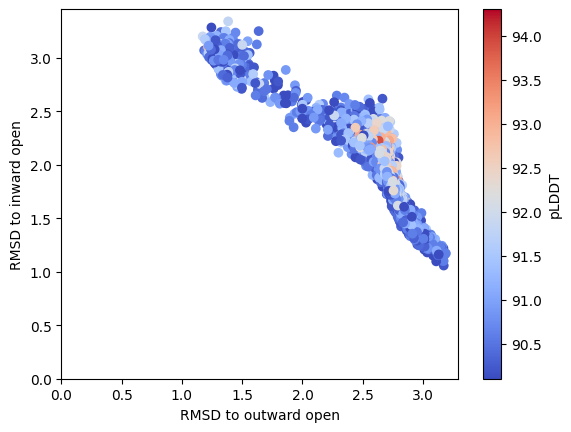

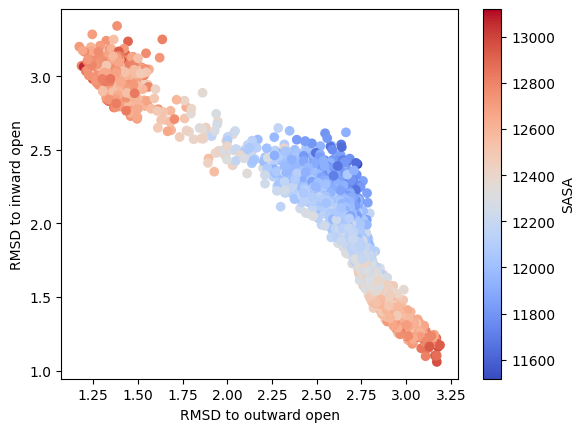

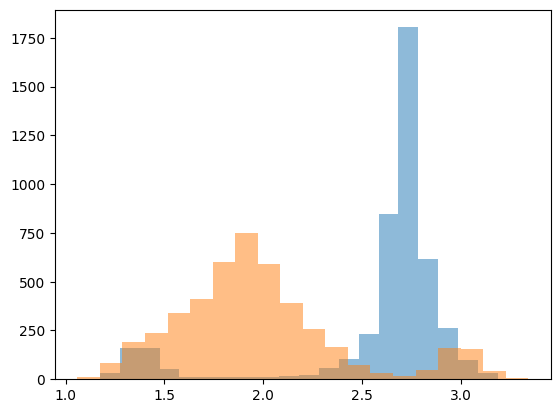

In [13]:
# make plots
if use_reference_structures:

    # display tables of closest to reference structures, lowest sasa, and most different
    print('Closest to outward open:')
    display(ensemble_df.sort_values(by=['rmsd_to_outward']).head(1)[['structure', 'pDDLDT', 'rmsd_to_outward', 'PC1', 'PC2']])
    print('Closest to inward open:')
    display(ensemble_df.sort_values(by=['rmsd_to_inward']).head(1)[['structure', 'pDDLDT', 'rmsd_to_inward', 'PC1', 'PC2']])

    # plot the rmsd to the reference structures
    plt.scatter(ensemble_df['rmsd_to_outward'], ensemble_df['rmsd_to_inward'], c=ensemble_df['pDDLDT'], cmap='coolwarm')
    plt.xlabel('RMSD to outward open')
    plt.ylabel('RMSD to inward open')
    plt.colorbar(label='pLDDT')
    #limits
    plt.xlim(0)
    plt.ylim(0)
    plt.show()

        # plot the rmsd to the reference structures
    plt.scatter(ensemble_df['rmsd_to_outward'], ensemble_df['rmsd_to_inward'], c=ensemble_df['sasa'], cmap='coolwarm')
    plt.xlabel('RMSD to outward open')
    plt.ylabel('RMSD to inward open')
    plt.colorbar(label='SASA')
    plt.show()


    # plot histogram of rmsd to outward open
    plt.hist(ensemble_df['rmsd_to_outward'], bins=20, alpha=0.5, label='outward open')
    plt.hist(ensemble_df['rmsd_to_inward'], bins=20, alpha=0.5, label='inward open')

else:

    # display tables of closest to reference structures, lowest sasa, and most different
    print('Represnetative structures from each cluster:')
    for i in ref_structures:
        display(ensemble_df.sort_values(by=['rmsd_to_' + i]).head(1)[['structure', 'pDDLDT', 'PC1', 'PC2']])
    print('Lowest 3 SASA:')
    display(ensemble_df.sort_values(by=['sasa']).head(3)[['structure', 'cluster', 'pDDLDT', 'PC1', 'PC2']])
    
    
    # plot ensemble
    plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df[plot_variable_3], cmap='coolwarm')
    plt.xlabel(plot_variable_1)
    plt.ylabel(plot_variable_2)
    plt.colorbar(label=plot_variable_3)
    
    # annotate reference structures
    for i in ref_structures:
        plt.scatter(ensemble_df.loc[ensemble_df['structure'] == i][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == i][plot_variable_2], c='black', marker='x', s=100)
        plt.annotate(i, (ensemble_df.loc[ensemble_df['structure'] == i][plot_variable_1], ensemble_df.loc[ensemble_df['structure'] == i][plot_variable_2]))
    plt.show()
    
    # for each reference structure, plot the histogram of rmsd to that structure
    for i in ref_structures:
        plt.hist(ensemble_df['rmsd_to_' + i], bins=20, alpha=0.5, label=i)
    plt.legend(loc='upper right')
    plt.xlabel('RMSD')
    plt.ylabel('Count')
    plt.xlim(0)
    fig = plt.gcf()
    fig.set_size_inches(10, 2)
    plt.show()
    
    # plot 2 pane histogram of SASA and pLDDT scores
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(ensemble_df['sasa'], bins=20, alpha=0.5, label='sasa', color='C3')
    ax1.set_xlabel('SASA')
    ax1.set_ylabel('Count')
    ax2.hist(ensemble_df['pDDLDT'], bins=20, alpha=0.5, label='pDDLDT')
    ax2.set_xlabel('pDDLDT')
    fig = plt.gcf()
    fig.set_size_inches(10, 2)
    plt.show()


In [14]:
# parallel calculation of the pairwise RMSD matrix (for the MC energy function used in the next cell)

## load backup matrix
rmsd_matrix = np.load(base_directory + 'rmsd_matrix_backup_90_bigsample.npy') # 'rmsd_matrix_80_6_0_3326-strucs.npy'

# # Initialize a matrix to store pairwise RMSD values
# rmsd_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
# 
# # function to calculate RMSD values in parallel
# def calculate_rmsd(i):
# 
#     rmsd_values = []
# 
#     # setup universe for i-th structure
#     mobile = mda.Universe(structure_directory + ensemble_df['structure'].values[i], structure_directory + ensemble_df['structure'].values[i])
#     if mobile.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
#         mobile.atoms.residues.resids += resid_offset
# 
#     for j in range(len(ensemble_df)):
# 
#         # setup universe for j-th structure
#         ref = mda.Universe(structure_directory + ensemble_df['structure'].values[j], structure_directory + ensemble_df['structure'].values[j])
#         if ref.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
#             ref.atoms.residues.resids += resid_offset
# 
#         # Calculate RMSD and store it in the list
#         rmsd = alignto(mobile, ref, select=rmsd_selection, match_atoms=True)[1]
#         rmsd_values.append(rmsd)
# 
#     mobile = None       # Release memory by setting the loaded structures to None
#     ref = None
# 
#     return rmsd_values
# 
# # Perform parallel computation of RMSD values
# with Pool(processes=num_processes) as pool:
#     results = list(tqdm(pool.imap(calculate_rmsd, range(len(ensemble_df))), total=len(ensemble_df)))
# 
# # Update the rmsd_matrix with the results
# for i, rmsd_values in enumerate(results):
#     rmsd_matrix[i] = rmsd_values
# 
# results = None  # Release memory by setting the results to None
# 
# np.save(base_directory + 'rmsd_matrix.npy', rmsd_matrix)    # save the matrix (to avoid recomputing it in the future)
# 
# # Display progress information
# print('Calculation completed for', len(ensemble_df), 'pairs of structures', end='\r')
# 
# # plot the matrix
# plt.imshow(rmsd_matrix, cmap='inferno')
# plt.colorbar()


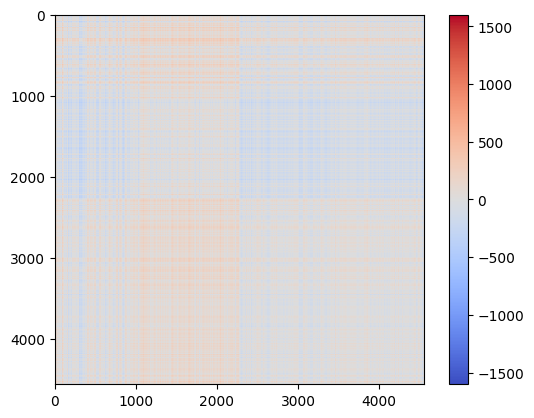

In [15]:
# make a matrix of pairwise SASA differences
sasa_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
n_elements = len(ensemble_df) * len(ensemble_df)

# all pairwise sasas (these can just be subtracted from eachother)
for i in range(len(ensemble_df)):
    for j in range(len(ensemble_df)):
        sasa_matrix[i,j] = (ensemble_df['sasa'].iloc[i] - ensemble_df['sasa'].iloc[j])
        #sasa_matrix[i,j] = (ensemble_df['sasa'][i] - ensemble_df['sasa'][j])

# show the matrix
plt.imshow(sasa_matrix, cmap='coolwarm')
plt.colorbar()


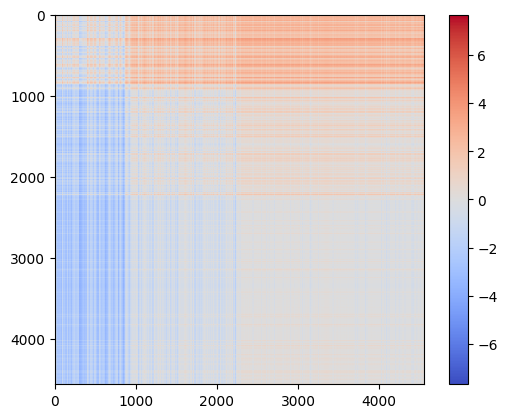

In [16]:
# make a matrix of differences in collective variable between structures
cv_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
n_elements = len(ensemble_df) * len(ensemble_df)

# all pairwise difference in collective variable (these can just be subtracted from eachother)
for i in range(len(ensemble_df)):
    for j in range(len(ensemble_df)):
        cv_matrix[i,j] = (ensemble_df[collective_variable].iloc[i] - ensemble_df[collective_variable].iloc[j])
        #cv_matrix[i,j] = (ensemble_df[collective_variable][i] - ensemble_df[collective_variable][j])

# show the matrix
plt.imshow(cv_matrix, cmap='coolwarm')
plt.colorbar()



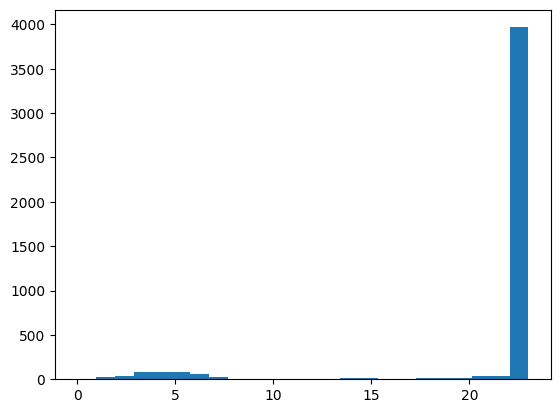

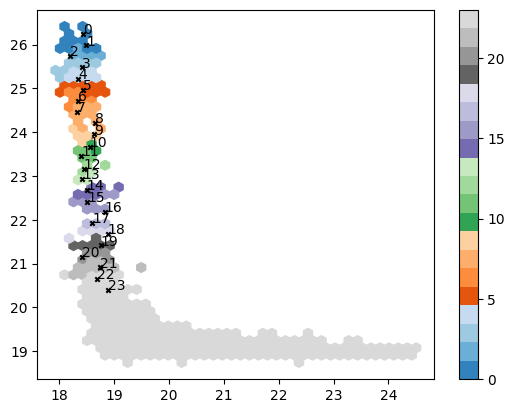

In [17]:
# assign bins for binned mc path finding

use_defined_end_states = True

occluded_state = 'msa-16-32_rank_024.pdb'
#lumen_open 'msa-128-256_rank_1163.pdb'
#cyto open 'msa-32-64_rank_127.pdb'

# end states to interpolate between values of the CV of
end_state_1 = 'msa-32-64_rank_127.pdb' #'' #msa-128-256_rank_1163.pdb
end_state_2 = occluded_state

# get the values of the CV for these structures
end_state_1_cv_value = ensemble_df[ensemble_df['structure'] == end_state_1][collective_variable].values[0]
end_state_2_cv_value = ensemble_df[ensemble_df['structure'] == end_state_2][collective_variable].values[0]

if use_defined_end_states == True:
    max_value = end_state_1_cv_value
    min_value = end_state_2_cv_value
else:
    # just get the min and max value of the end states globally, like before
    max_value = ensemble_df[collective_variable].max()
    min_value = ensemble_df[collective_variable].min()


## get the ideal collective variable values per window between min and max_value using linear interpolation
ideal_window_values = np.zeros(mc_n_bins)
for i in range(mc_n_bins):
    ideal_window_values[i] = np.interp(i, [0, mc_n_bins-1], [max_value, min_value])
ideal_initial_path = []
for i in ideal_window_values:
    ideal_initial_path.append(ensemble_df[collective_variable].sub(i).abs().idxmin())

# replace the first and last structures in the ideal path with the end states
if use_defined_end_states == True:
    ideal_initial_path[0] = ensemble_df[ensemble_df['structure'] == end_state_1].index[0]
    ideal_initial_path[-1] = ensemble_df[ensemble_df['structure'] == end_state_2].index[0]

## set up the bins for the binned path
ensemble_df['closest_ideal_structure'] = ensemble_df[collective_variable].apply(lambda x: ideal_initial_path[np.argmin(np.abs(ideal_window_values - x))])
ensemble_df['bin'] = ensemble_df['closest_ideal_structure'].apply(lambda x: ideal_initial_path.index(x))


# plotting
#display(ensemble_df)
plt.hist(ensemble_df['bin'], bins=mc_n_bins)
plt.show()

# show bin distribution
plt.hexbin(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], C=ensemble_df['bin'], cmap='tab20c', gridsize=40, reduce_C_function=np.amax)
#plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c')
plt.colorbar()

# plot the initial guesses
for i in range(mc_n_bins):
    plt.scatter(ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_1], ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_2], marker='x', color='black', s=10)
# label the ideal structures wit htheir associated bin
for i in range(mc_n_bins):
    plt.annotate(i, (ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_1], ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_2]))

plt.show()

100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


,energy,path structures
49,0.536119,"(msa-32-64_rank_127.pdb, msa-512-1024_rank_312.pdb, msa-256-512_rank_504.pdb, msa-64-128_rank_788.pdb, msa-64-128_rank_1087.pdb, msa-64-128_rank_300.pdb, msa-64-128_rank_446.pdb, msa-64-128_rank_1378.pdb, msa-64-128_rank_1223.pdb, msa-64-128_rank_1113.pdb, msa-64-128_rank_1208.pdb, msa-64-128_rank_541.pdb, msa-64-128_rank_708.pdb, msa-128-256_rank_776.pdb, msa-64-128_rank_1193.pdb, msa-128-256_rank_1239.pdb, msa-64-128_rank_1365.pdb, msa-128-256_rank_1173.pdb, msa-64-128_rank_1094.pdb, msa-64-128_rank_1202.pdb, msa-64-128_rank_1228.pdb, msa-64-128_rank_966.pdb, msa-64-128_rank_733.pdb, msa-16-32_rank_024.pdb)"
21,0.536119,"(msa-32-64_rank_127.pdb, msa-512-1024_rank_312.pdb, msa-256-512_rank_504.pdb, msa-64-128_rank_788.pdb, msa-64-128_rank_1087.pdb, msa-64-128_rank_300.pdb, msa-64-128_rank_446.pdb, msa-64-128_rank_1378.pdb, msa-64-128_rank_1223.pdb, msa-64-128_rank_1113.pdb, msa-64-128_rank_1208.pdb, msa-64-128_rank_541.pdb, msa-64-128_rank_708.pdb, msa-128-256_rank_776.pdb, msa-64-128_rank_1193.pdb, msa-128-256_rank_1239.pdb, msa-64-128_rank_1365.pdb, msa-128-256_rank_1173.pdb, msa-64-128_rank_1094.pdb, msa-64-128_rank_1202.pdb, msa-64-128_rank_1228.pdb, msa-64-128_rank_966.pdb, msa-64-128_rank_733.pdb, msa-16-32_rank_024.pdb)"
26,0.536119,"(msa-32-64_rank_127.pdb, msa-512-1024_rank_312.pdb, msa-256-512_rank_504.pdb, msa-64-128_rank_788.pdb, msa-64-128_rank_1087.pdb, msa-64-128_rank_300.pdb, msa-64-128_rank_446.pdb, msa-64-128_rank_1378.pdb, msa-64-128_rank_1223.pdb, msa-64-128_rank_1113.pdb, msa-64-128_rank_1208.pdb, msa-64-128_rank_541.pdb, msa-64-128_rank_708.pdb, msa-128-256_rank_776.pdb, msa-64-128_rank_1193.pdb, msa-128-256_rank_1239.pdb, msa-64-128_rank_1365.pdb, msa-128-256_rank_1173.pdb, msa-64-128_rank_1094.pdb, msa-64-128_rank_1202.pdb, msa-64-128_rank_1228.pdb, msa-64-128_rank_966.pdb, msa-64-128_rank_733.pdb, msa-16-32_rank_024.pdb)"


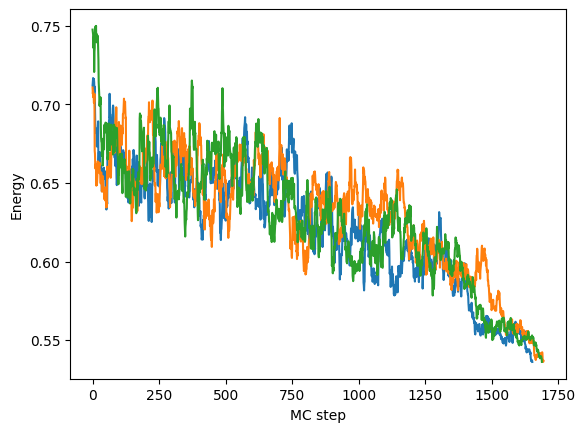

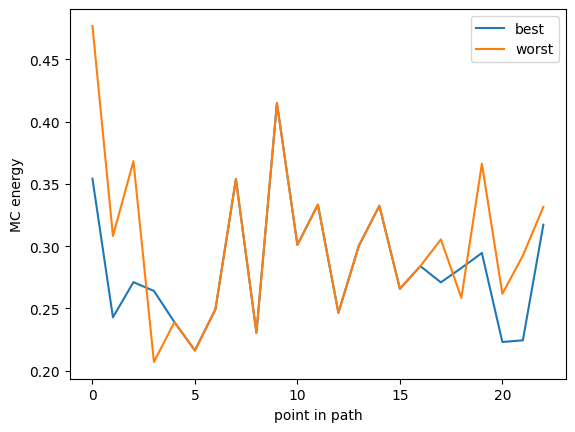

In [141]:
# MC path finding by exchanging structures within bins

def calc_energy(path, path_length):

    wf_rmsd = 1
    wf_cv = 1

    # for minimising rmsd between structures on path
    energy_rmsd = 0
    for i in range(path_length - 1):
        energy_rmsd += (rmsd_matrix[np.where(ensemble_df.index.values == path[i])[0][0], np.where(ensemble_df.index.values == path[i+1])[0][0]]**2)
    energy_rmsd = wf_rmsd * np.sqrt ( 1/path_length * energy_rmsd )

    # for minimising pairwise differences in collective variable between structures on path
    energy_cv = 0
    for i in range(path_length -1):
        energy_cv += (cv_matrix[np.where(ensemble_df.index.values == path[i])[0][0], np.where(ensemble_df.index.values == path[i+1])[0][0]]**2)
    energy_cv = wf_cv * np.sqrt ( 1/path_length * energy_cv )

    # final term is sum
    total_energy = 0
    total_energy = energy_rmsd + energy_cv

    # final energy
    return total_energy

# define a function that runs monte carlo simulated annealing to optimise path smoothness
def mc_path_optimisation(seed):

    fixed_endpoints = True
    mc_n_steps = 1000
    initial_temperature = 0.01
    cooling_factor = 10000 # initial temp is divided by this to get the final temperature

    np.random.seed(seed)

    # list of temperatures mapped to mc_n_steps decreasing stepwise in 10 increments
    final_temperature = initial_temperature/cooling_factor
    temperatures = np.logspace(np.log10(initial_temperature), np.log10(final_temperature), num=mc_n_steps)

    mc_path_length = mc_n_bins

    mcpath = []

    initial_guess_indices = []
    initial_guess_indices = ideal_initial_path

    mcpath = initial_guess_indices

    # dictionary of paths and energies
    path_energies = {}

    # run n_mc_runs steps
    for i in range(mc_n_steps):

        temperature = temperatures[i]

        # calculate energy of the initial path
        energy = 0
        energy = calc_energy(mcpath, mc_path_length)
        
        # propose an exchange of a random (not endstate) structure in the path with a random structure from the pool
        new_mcpath = mcpath.copy()

        if fixed_endpoints == True:
            start_point = 1
            end_point = len(new_mcpath)-1
        else:
            start_point = 0
            end_point = len(new_mcpath)

        # loop throguh new_mcpath
        for point in range(start_point, end_point):

            new_mcpath = mcpath.copy()
            
            structure_in_path = mcpath[point]

            # select a random structure in the same bin as the structure in the path
            random_structure_in_pool = np.random.choice(ensemble_df[ensemble_df['bin'] == ensemble_df.loc[structure_in_path]['bin']].index.values)

            # replace the random structure in the new path with the random structure from the pool
            new_mcpath[np.where(new_mcpath == structure_in_path)[0][0]] = random_structure_in_pool

            # calculate the energy of the original path
            energy = 0
            energy = calc_energy(mcpath, mc_path_length)

            # calcualte energy of proposed path
            new_energy = 0
            new_energy = calc_energy(new_mcpath, mc_path_length)

            # calculate the difference between the two energies
            delta_energy = 0
            delta_energy = new_energy - energy

            # metropolis criterion

            # if lower, accept the new path
            if delta_energy < 0:
                descision = 'accepted'
                mcpath = new_mcpath
                path_energies[new_energy] = mcpath
            else:
            
                # if higher, accept with probability e^(-difference/temp)
                if np.random.rand() < np.exp(-delta_energy / temperature):
                    descision = 'accepted'
                    mcpath = new_mcpath
                    path_energies[new_energy] = mcpath
                else:
                    descision = 'rejected'
                    pass
            
            # do not uncomment this when running in parallel, will break your editor
            #print('dE:',delta_energy,' T:', temperature, ' rand:', np.exp(-delta_energy / temperature), descision)
            
    # get the path with the lowest energy
    final_energy = min(path_energies.keys())
    final_path = path_energies[final_energy]
    relaxation_energies = list(path_energies.keys())
    final_path_structures = tuple(ensemble_df.loc[final_path]['structure'].values)

    return [final_energy, final_path, final_path_structures, relaxation_energies]

#  run once for testing
#  random seed
# seed = np.random.randint(0, 1000000)
# mc_runs = []
# mc_runs.append(mc_path_optimisation(seed))

mc_n_runs = 100

# run mc_n_bins runs in parallel

# re-randomised, nonreproduciible version
# seeds = np.random.randint(low=0, high=1e3, size=mc_n_runs)  # Create a list of random seeds
# with Pool(processes=num_processes) as pool:
#     mc_runs = list(tqdm(pool.imap(mc_path_optimisation, zip(range(mc_n_runs), seeds)), total=mc_n_runs))

# reproducible version
with Pool(processes=num_processes) as pool:
    mc_runs = list(tqdm(pool.imap(mc_path_optimisation, range(mc_n_runs)), total=mc_n_runs))

# add the final energies and final path structures to a dataframe
mc_runs_df = pd.DataFrame(mc_runs, columns=['energy', 'path', 'path structures', 'relaxation energies'])
mc_runs_df = mc_runs_df.sort_values(by=['energy']) 

# display the best run
display(mc_runs_df[['energy', 'path structures']].head(3))

# plot relaxation of the best run
for i in range(1, 4):
    plt.plot(mc_runs_df.iloc[i]['relaxation energies'])

# label
plt.xlabel('MC step')
plt.ylabel('Energy')
plt.show()

# calculate the energy for each point in the best path (mc_runs[1]) (for plotting)
energy_over_path = []
energy = {}

# get hte "path" of the best run (in indices)
test = mc_runs_df.iloc[0]['path']
for i in range(mc_n_bins - 1):
        energy[i] = (rmsd_matrix[np.where(ensemble_df.index.values == test[i])[0][0], np.where(ensemble_df.index.values == test[i+1])[0][0]]**2)
        energy[i] = np.sqrt ( 1 * energy[i] )
plt.plot(energy.values(), label='best')
test = mc_runs_df.iloc[-1]['path']
for i in range(mc_n_bins - 1):
        energy[i] = (rmsd_matrix[np.where(ensemble_df.index.values == test[i])[0][0], np.where(ensemble_df.index.values == test[i+1])[0][0]]**2)
        energy[i] = np.sqrt ( 1 * energy[i] )
plt.plot(energy.values(), label='worst')
# plot energy

# plot energy
plt.legend()
# label axes
plt.xlabel('point in path')
plt.ylabel('MC energy')
plt.show()

# write out the best run to a multistate pdb file and append timestamp to filename
with mda.Writer(base_directory + 'best_run.pdb', u.atoms.n_atoms) as W:
    # get the structures of the lowest energy path
    for structure in mc_runs_df.head(1)['path structures'].values[0]:
        # if structure is the reference, dont renumber residues
        if structure == 'ref_outward.pdb' or structure == 'ref_inward.pdb':
            # use a non-reference structure to make the universe
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset 
            u.atoms.segments.segids = 'A'
            u.atoms.chainIDs = 'A'
            W.write(u.select_atoms('protein'))
        else:
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset
            W.write(u.select_atoms('protein'))
        

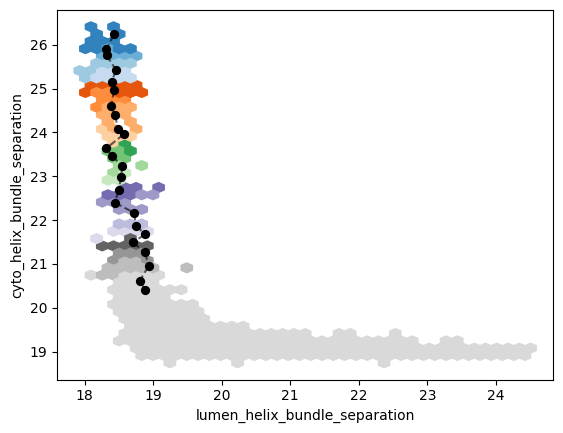

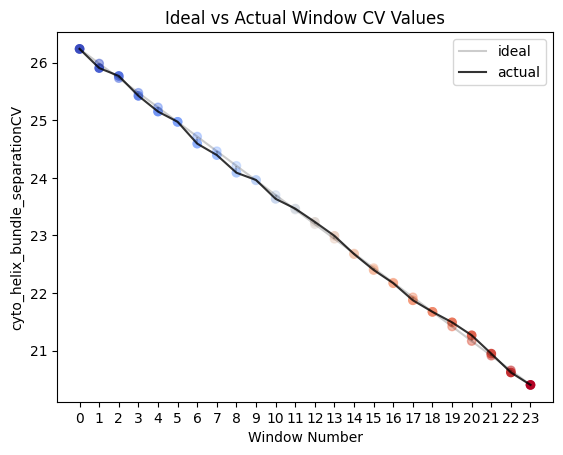

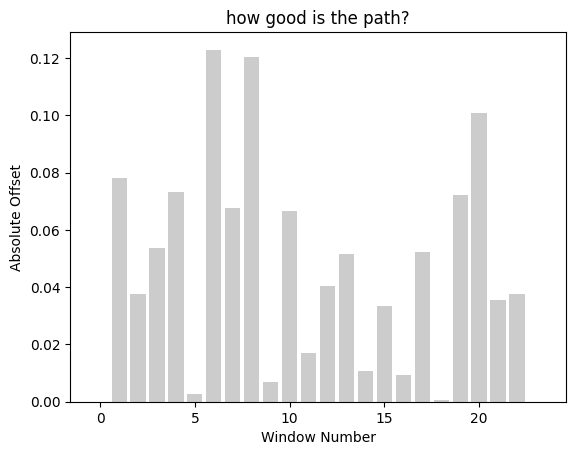

In [140]:
# plot the best path

# plot all the structures
plt.hexbin(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], C=ensemble_df['bin'], cmap='tab20c', gridsize=40, reduce_C_function=np.amax)
#
#plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c', alpha=0.8, s=2)
# plot all the structures as a hexgrid 


# for each structure in best run, plot the rmsd to outward and inward from the ensemble_df dataframe
for structure in mc_runs_df.head(1)['path'].values[0]:
    plt.scatter(ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2], c='black', s=32)
    # annotate them with their bin number
    #plt.annotate(ensemble_df.loc[structure]['bin'], (ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]), xytext=(ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]+0.5), ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# draw connecting lines
for i in range(len(mc_runs_df.head(1)['path'].values[0]) - 1):
    # get the rmsd to outward and inward from ensemble_df
    x1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_1]
    y1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_2]
    x2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_1]
    y2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_2]
    plt.plot([x1, x2], [y1, y2], c='black', alpha=0.6, linestyle='dashed')

# plot the initial guesses
#for i in range(mc_n_bins):
#    plt.scatter(ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_1], ensemble_df.loc[ensemble_df.index == ideal_initial_path[i]][plot_variable_2], marker='x', color='black', s=10)

#display(mc_runs_df.head(1))
#display(mc_runs_df.tail(1))

plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.show()

# Plot how good this is

# plot the ideal window values
plt.plot(ideal_window_values, label='ideal', color='black', alpha=0.2)
# show dots
plt.scatter(range(mc_n_bins), ideal_window_values, c=range(mc_n_bins), cmap='coolwarm', alpha=0.5)

# get the actual values
actual_window_values = np.zeros(mc_n_bins)
for i in range(mc_n_bins):
    actual_window_values[i] = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][collective_variable]

## print the ideal and actual values in a table (rounded to 2 decimal places)
#print(pd.DataFrame({'ideal': ideal_window_values, 'actual': actual_window_values}).round(2))

# plot the actual values
plt.plot(actual_window_values, label='actual', c='black', alpha=0.8)
# show dots
plt.scatter(range(mc_n_bins), actual_window_values, c=range(mc_n_bins), cmap='coolwarm')

# plot vertical lines between the two
for i in range(mc_n_bins):
    plt.plot([i, i], [ideal_window_values[i], actual_window_values[i]], c='black', alpha=0.2, linestyle='dashed')

if ideal_initial_path == True:

    # alternate where initial guessi ncides are just those of the structures closest to the ideal values of the collective variable (from a linear interpolation)
    initial_guess_indices = []
    # get the ideal values of the collective variable

    # enpoint values are min adn max of the collective variable
    ideal_values = np.linspace(ensemble_df[collective_variable].min(), ensemble_df[collective_variable].max(), mc_n_bins)

    # get the closest structure to each ideal value
    for i in ideal_values:
        initial_guess_indices.append(ensemble_df[collective_variable].sub(i).abs().idxmin())
    # plot the initial guesses
    for i in range(mc_n_bins):
        plt.scatter(i, ensemble_df.loc[initial_guess_indices[i]][collective_variable], marker='x', color='black')
    print(len(initial_guess_indices))   

# x axis labels
plt.xticks(range(mc_n_bins), range(mc_n_bins))
plt.xlabel('Window Number')
plt.ylabel(collective_variable + 'CV')
plt.legend()

# add a title
plt.title('Ideal vs Actual Window CV Values')
plt.show()

# now just plot the offsets (absolute) as a bar chart
offsets = np.abs(ideal_window_values - actual_window_values)
plt.bar(range(mc_n_bins), offsets, color='black', alpha=0.2)
plt.xlabel('Window Number')
plt.ylabel('Absolute Offset')
plt.title('how good is the path?')
plt.show()


In [142]:
# set up umbrella sampling windows (for REUS)
from MDAnalysis.analysis import align, rms
import shutil
from difflib import SequenceMatcher

def write_pca_ref_pdb():

    # write a file like pca1.pdb but with "REMARK TYPE=OPTIMAL" after each ENDMDL line
    # edit this file to add "REMARK TYPE=OPTIMAL" after each ENDMDL line
    with open(umbrella_sampling_directory + 'pca_ref.pdb', 'r') as file :
        filedata = file.read()
    # Replace the target string
    filedata = filedata.replace('ENDMDL', 'ENDMDL\nREMARK TYPE=OPTIMAL')
    # Write the file out again
    with open(umbrella_sampling_directory + 'pca_ref.pdb', 'w') as file:
        file.write(filedata)

# function to calculate the similarity between two strings
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# this should be a pdb from e.g. an unbiased simulation you've run before
# containing everything in the simualtion box, protein, lipids, water etc. 
# if you have a working topolgy for this system, you can re-use it here
template_pdb_for_umbrella_sampling = (base_directory + 'template.pdb')

# make a universe from this template
u_template = mda.Universe(template_pdb_for_umbrella_sampling, template_pdb_for_umbrella_sampling)

# sort out your collective variable, for later inclusion in the
# automatically generated plumed input file
print('collective variable is:', collective_variable, '\n')
if collective_variable == 'cyto_helix_bundle_separation':
    com1 = cyto_helix_bundle_1
    com2 = cyto_helix_bundle_2
    pcavar = False
elif collective_variable == 'lumen_helix_bundle_separation':
    com1 = lumen_helix_bundle_1
    com2 = lumen_helix_bundle_2
    pcavar = False
elif collective_variable == 'PC1':
    com1 = None
    com2 = None
    pcavar = True
    write_pca_ref_pdb()
    pca_ref_pdb = umbrella_sampling_directory + 'pca_ref.pdb'
else:
    print('I dont know what your collective variable is supposed to be, sort this out yourself (thinking emoji)')
    com1 = '{your atoms here}'
    com2 = '{your atoms here}'
    pcavar = False


# align a mobile universe to a reference universe
def align_universe(mobile, ref):
# aligns mobile universe to first frame of reference universe
    alignment_selection = 'protein and name CA'
    mobile.trajectory[-1]  # set mobile trajectory to last frame
    ref.trajectory[0]  # set reference trajectory to first frame
    mobile_ca = mobile.select_atoms(alignment_selection)
    ref_ca = ref.select_atoms(alignment_selection)
    rms.rmsd(
             mobile_ca.positions, 
             ref_ca.positions, 
             superposition=False
             )
    aligner = align.AlignTraj(mobile, 
                              ref, 
                              select=alignment_selection,
                              in_memory=True).run()
    return mobile

# replace the protein coordinates in your template with those from a structure in the ensemble
def protein_coordinate_replacer(u_structure, u_template):

    # dictionary of name matches for charmm36 (and I assume amber)
    # key is the name in the template universe, value is the name in the structure universe
    name_mismatches = {
    'ALA HN'   : 'H',
    'ARG HB1'  : 'HB2',
    'ARG HB2'  : 'HB3',
    'ARG HD1'  : 'HD2',
    'ARG HD2'  : 'HD3',
    'ARG HG1'  : 'HG2',
    'ARG HG2'  : 'HG3',
    'ARG HN'   : 'H',
    'ASN HB1'  : 'HB2',
    'ASN HB2'  : 'HB3',
    'ASN HN'   : 'H',
    'ASP HB1'  : 'HB2',
    'ASP HB2'  : 'HB3',
    'ASP HN'   : 'H',
    'CYS HB1'  : 'HB2',
    'CYS HB2'  : 'HB3',
    'CYS HG1'  : 'HG',
    'CYS HN'   : 'H',
    'GLN HB1'  : 'HB2',
    'GLN HB2'  : 'HB3',
    'GLN HG1'  : 'HG2',
    'GLN HG2'  : 'HG3',
    'GLN HN'   : 'H',
    'GLU HB1'  : 'HB2',
    'GLU HB2'  : 'HB3',
    'GLU HG1'  : 'HG2',
    'GLU HG2'  : 'HG3',
    'GLU HN'   : 'H',
    'GLY HA1'  : 'HA2',
    'GLY HA2'  : 'HA3',
    'GLY HN'   : 'H',
    'HSD HB1'  : 'HB2',
    'HSD HB2'  : 'HB3',
    'HSD HN'   : 'H',
    'LEU HN'   : 'H',
    'LYS HB1'  : 'HB2',
    'LYS HB2'  : 'HB3',   
    'LYS HD1'  : 'HD2',
    'LYS HD2'  : 'HD3',
    'LYS HE1'  : 'HE2',
    'LYS HE2'  : 'HE3',
    'LYS HG1'  : 'HG2',
    'LYS HG2'  : 'HG3',
    'LYS HN'   : 'H',
    'MET HB1'  : 'HB2',
    'MET HB2'  : 'HB3',
    'MET HG1'  : 'HG2',
    'MET HG2'  : 'HG3',
    'MET HN'   : 'H',
    'PHE HB1'  : 'HB2',
    'PHE HB2'  : 'HB3',
    'PHE HN'   : 'H',
    'PRO HB1'  : 'HB2',
    'PRO HB2'  : 'HB3',
    'PRO HD1'  : 'HD2',
    'PRO HD2'  : 'HD3',
    'PRO HG1'  : 'HG2',
    'PRO HG2'  : 'HG3',
    'SER HB1'  : 'HB2',
    'SER HB2'  : 'HB3',
    'SER HG1'  : 'HG',
    'SER HN'   : 'H',
    'THR HN'   : 'H',
    'TRP HB1'  : 'HB2',
    'TRP HB2'  : 'HB3',
    'TRP HN'   : 'H',
    'TYR HB1'  : 'HB2',
    'TYR HB2'  : 'HB3',
    'TYR HN'   : 'H',
    'ILE CD'   : 'CD1',
    'ILE HD1'  : 'HD11',
    'ILE HD2'  : 'HD12',
    'ILE HD3'  : 'HD13', 
    'ILE HG11' : 'HG12',
    'ILE HG12' : 'HG13',
    'ILE HN'   : 'H',
    'LEU HB1' : 'HB2',
    'LEU HB1' : 'HB2',
    'VAL HN'  : 'H',
    }


    error_counter = 0
    error_type_list = []

    # renumber the residues in the structure universe
    u_structure.atoms.residues.resids += resid_offset

    # dict to keep track of which atoms in the structure universe have been accounted for (residue: atom)
    modified_atoms = []

    # loop though each atom in the template universe matching the atom name and residue ID to the atom in the template universe
    for atom in u_template.select_atoms('protein').atoms:

        atom_name_template = atom.name

        # if name is in the name_mismatches dictionary, search for the replacement name
        if (atom.resname + ' ' + atom.name) in name_mismatches.keys():
            #print('mismatched atom name: ', atom.name, 'in residue: ', atom.resname, 'replacing with: ', name_mismatches[(atom.resname + ' ' + atom.name)])
            atom_name_template = name_mismatches[(atom.resname + ' ' + atom.name)]

        # match atom with same name and residue ID in the structure universe (from AF ensemble)
        atom_name_structure = u_structure.atoms[(u_structure.atoms.names == atom_name_template) & (u_structure.atoms.resids == atom.resid) ].names

        # if the atom is found in the structure universe, replace the coordinates
        if len(atom_name_structure) > 0:

            # replace the coordinates of the atom in the template universe with the coordinates of the atom in the structure universe
            atom.position = u_structure.atoms[(u_structure.atoms.names == atom_name_template) & (u_structure.atoms.resids == atom.resid) ].positions

            # append the atom to a list of atoms
            modified_atoms.append((str(atom.resid) + str(atom.name)))

        else:
            print('ERROR: with: ', atom.name, atom.resname)

            # add this to a list of resname atom name pairs that are not found in the structure universe
            error_type_list.append((atom.resname, atom.name))

            error_counter += 1
            # handle mismatching atoms 

            # check that the residue itself is present
            if atom.resid in u_structure.atoms.resids:              # if the resid for this missing atom is in the structure universe

                pass
                #print('no atom in resid', atom.resid, atom.resname, 'with name: ', atom.name, 'found')
            
                #    # get the average position of the atoms in the structure universe with the same resid
                #    incomplete_resid_average_position_structure = np.mean(u_structure.atoms[u_structure.atoms.resids == atom.resid].positions, axis=0)
                #    # get the average position of the atoms in the template universe with the same resid
                #    incomplete_resid_average_position_template = np.mean(u_template.atoms[u_template.atoms.resids == atom.resid].positions, axis=0) 
                #    # get the vector between the two averages
                #    fudge_position_vector = incomplete_resid_average_position_structure - incomplete_resid_average_position_template
                #    # add the vector to the atom position in the template universe
                #    atom.position = atom.position + fudge_position_vector

            else:
                print('ERROR: resid not found in structure universe: ', atom.resid)

    print('number of atoms not found in structure universe: ', error_counter)
    # print unique error types in the list
    display(set(error_type_list))
    return u_template.atoms.positions # not important becauase the universe is modified in place, just return something

# turns your mda selection token into a safe list of atom IDs to pass to PLUMED
# because MOLINFO may or may not work depending on what python interpreter
# you have available at runtime
def selection_parser(mda_selection):
    selection_string = ''
    for i in u_template.select_atoms(mda_selection).atoms.ids:
        selection_string += str(i) + ','
    selection_string = selection_string[:-1]
    return selection_string

# write a plumed input file for REUS, if your CV is not a distance then
# you will need to modify this script appropriately
def plumed_input_writer(window_values, plumed_file, force_constant=1000):

    with open(plumed_file, 'w') as f:
        f.write('MOLINFO STRUCTURE=%s \n\n' % template_pdb_for_umbrella_sampling) #window_0/window_0.pdb
        if pcavar == True:
            f.write('CV: PCAVARS REFERENCE=%s TYPE=OPTIMAL\n\n' % pca_ref_pdb) #{@mda:{}}
        else:
            f.write('com1: CENTER ATOMS=%s \n' % selection_parser(com1)) #{@mda:{}}
            f.write('com2: CENTER ATOMS=%s \n' % selection_parser(com2)) #{@mda:{}}
            f.write('\n')
            f.write('CV: DISTANCE ATOMS=com1,com2 \n\n')
        f.write('umbrella_restraint: RESTRAINT ARG=CV KAPPA=%s AT=@replicas:' % force_constant)
        for i in window_values:
            # should be no comma after the last value
            if i == window_values[-1]:
                f.write(str(i.round(4)) + '\n')
            else:
                f.write(str(i.round(4)) + ',')
        f.write('\nPRINT ARG=CV,umbrella_restraint.* FILE=COLVAR_MULTI\n')
        f.write('\n')

# prepare directories for each window
umbrella_sampling_directory = base_directory + 'umbrella_sampling/'
window_directories = []
for i in range(mc_n_bins):
    window_directories.append(umbrella_sampling_directory + 'window_' + str(i))
    if not os.path.exists(window_directories[i]):
        os.makedirs(window_directories[i])
    shutil.copy(structure_directory + mc_runs_df.head(1)['path structures'].values[0][i], window_directories[i])    # copy the relevant structure in mc_runs_df to the window directory

# for each window, replace the coordinates of the protein in the template universe with the coordinates of the structure at the corresponding index in the best path
for i in range(mc_n_bins):

    # make a copy of the template universe
    u = u_template.copy()

    # make a universe out of the structure corresponding to the index in the best path
    structure = mc_runs_df.head(1)['path structures'].values[0][i]
    u_structure = mda.Universe(structure_directory + structure, structure_directory + structure)

    # align the structure to the template universe
    u_structure = align_universe(u_structure, u)
    new_coordinates = protein_coordinate_replacer(u_structure, u)

    # write out the universe to a pdb file
    u.atoms.write(window_directories[i] + '/window_' + str(i) + '.pdb')

# write out the plumed input file
plumed_input_writer(ideal_window_values, umbrella_sampling_directory + '/plumed.dat')

collective variable is: cyto_helix_bundle_separation 

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD1 HSD
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  7


{('ASP', 'HD2'),
 ('HSD', 'HD1'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

ERROR: with:  HT1 LEU
ERROR: with:  HT2 LEU
ERROR: with:  HD2 ASP
ERROR: with:  OT1 TYR
ERROR: with:  OT2 TYR
ERROR: with:  HT2B TYR
number of atoms not found in structure universe:  6


{('ASP', 'HD2'),
 ('LEU', 'HT1'),
 ('LEU', 'HT2'),
 ('TYR', 'HT2B'),
 ('TYR', 'OT1'),
 ('TYR', 'OT2')}

In [ ]:
# run propka
from propkatraj import PropkaTraj

residues = ['205', '305', '332', '346', '273', '280', '335'] # residues of interest, must appear in the propkatraj output dataframe
pka_df = ensemble_df      # copy dataframe 

# results array
pka_results = np.zeros((len(structures), len(residues)))
for structure in structures[1:]:
    
    # make a universe
    u = mda.Universe(structure_directory + structure, structure_directory + structure)
    u.atoms.residues.resids += resid_offset
    u.atoms.segments.segids = 'A'
    u.atoms.chainIDs = 'A'

    # run propka 
    pkatraj = PropkaTraj(u, select='protein', skip_failure=True, Verbose=True)
    pkatraj.run() # the dataframe is pkatraj.results.pkas
    
    # store results
    for resid in residues:
        try:
          pka_results[structures.index(structure), residues.index(resid)] = pkatraj.results.pkas[int(resid)]
        except KeyError:
          pka_results[structures.index(structure), residues.index(resid)] = np.nan

# make a dataframe
pka_df = pd.DataFrame(pka_results, columns=residues, index=structures)
        

In [ ]:
# plot the pKas

def plot_ensemble_pka(resid, pH, pH_span=3):

    plt.hexbin(ensemble_df_pka[plot_variable_1], ensemble_df_pka[plot_variable_2], C=ensemble_df_pka['pka_' + resid], cmap='coolwarm_r', gridsize=30, reduce_C_function=np.nanmean)
    plt.xlabel(plot_variable_1)
    plt.ylabel(plot_variable_2)

    plt.colorbar(label='pKa')
    plt.clim(pH-pH_span, pH+pH_span)

    ## labels
    plt.title('AF ensemble: pKa resID ' + resid)
    plt.annotate('IF',  (0.20, 0.95), xycoords='axes fraction', ha='left',  va='top', alpha=1)
    plt.annotate('OF',  (0.95, 0.20), xycoords='axes fraction', ha='right', va='top', alpha=1)
    plt.annotate('OCC', (0.30, 0.25), xycoords='axes fraction', ha='left',  va='top', alpha=1)

    plt.show()

# make a copy of the ensemble_df dataframe with the pka values added
ensemble_df_pka = ensemble_df.copy()
for resid in residues:
    ensemble_df_pka['pka_' + resid] = pka_df[resid].values
ensemble_df_pka = ensemble_df_pka.replace(0, np.nan)    # set all zeros to nan

luminal_residues = ['205', '332', '335', '273']
cyto_residues = ['305', '346', '280']

for resid in luminal_residues:
    plot_ensemble_pka(resid, pH=5)

for resid in cyto_residues:
    plot_ensemble_pka(resid, pH=7)

